# Overview

1. Using fastai to get the data easily (imagenet images).  I think this is also possible via tensorflow but their datasets stuff is terrible with 2.0 version tf

2. Using pretrained model and stuff from keras.  Not necessary but gives us a model that is fairly accurate already with a lot of layers.  Otherwise training a model and getting high accuracy is whole ordeal.

3. Using adversarial robustness toolbox to generate adversarial attacks.  Many more options available for adversarial attacks but using fgsm as its one of the more easy to understand.  

4. Using TCAV stuff I implemented to generate sensitivity scores on adversarial attacks and noisy data that serves as counterexamples.  

In [69]:
from pathlib import Path
from typing import Union
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from fastai.data import *
from fastai.data.all import *

# adversarial attack imports
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod


In [2]:
# unless i reconfigure the TCAV stuff to use eager execution this is necessary
# but this also creates a headache in terms of using the data and whatnot as I couldnt 
# understand how to get some parts working with eager execution related to the model fit/compile part
# tf.compat.v1.enable_eager_execution()
tf.compat.v1.disable_eager_execution()


# data related

In [3]:
path = untar_data(URLs.IMAGENETTE_320)


In [4]:
fnames = get_image_files(path)

# these are from fastai tutorial info.  is there not an easy way to get the id -> label?
label_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

label_array = list(label_dict.values())

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

train_folder = path / "train"
def get_all_subfolder_images(folder):
    images = []
    labels = []
    for idx, key in enumerate(label_dict.keys()):
        label_folder = folder / key
        image_paths = list(label_folder.glob('*.JPEG'))
        imgs = [tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE) for p in image_paths]
        imgs = [tf.keras.preprocessing.image.img_to_array(img)/255 for img in imgs]
        labels_ = [idx for _ in range(len(imgs))]
        images.extend(imgs)
        labels.extend(labels_)
    
    return np.array(images), np.array(labels)

images, labels = get_all_subfolder_images(path / "train")
val_images, val_labels = get_all_subfolder_images(path / "val")

labels_binary = tf.keras.utils.to_categorical(labels)
val_labels_binary = tf.keras.utils.to_categorical(val_labels)
assert len(images) == len(labels)

In [6]:
images[0].shape

(160, 160, 3)

Text(0.5, 1.0, '0')

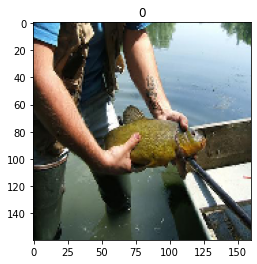

In [7]:
plt.imshow(images[0])
plt.title(f"{labels[0]}")


## plot some images

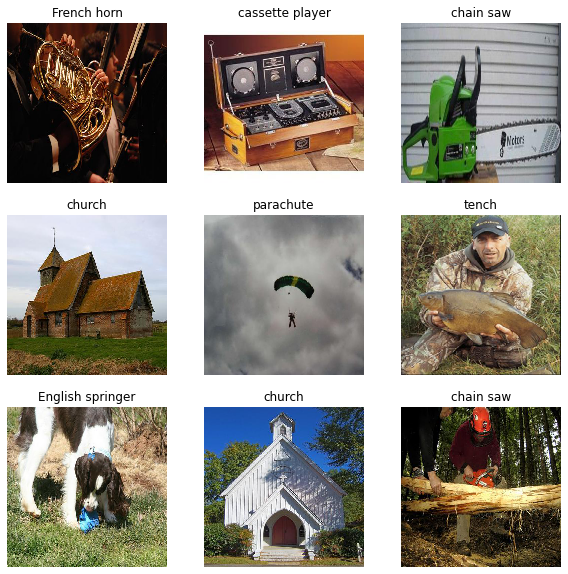

In [8]:
# class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
# images, labels = next(iter(train_dataset))

for i in range(9):
    rand_idx = random.randint(0, len(images))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[rand_idx])
    plt.title(label_array[labels[rand_idx]])
    plt.axis("off")

In [14]:
images[0].shape


(160, 160, 3)

# Use pretrained model

In [15]:
labels_binary.shape

(9469, 10)

In [16]:
# -------------- 

base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False, 
    input_shape=IMG_SHAPE, 
    weights="imagenet"
)

for layer in base_model.layers:
    layer.trainable = False
# add new classifier layers
flat = tf.keras.layers.Flatten()(base_model.layers[-1].output)
# class1 = tf.keras.layers.Dense(1024, activation='relu')(flat1)
output = tf.keras.layers.Dense(labels_binary.shape[1], activation='softmax')(flat)
# define new model
model = tf.keras.Model(inputs=base_model.inputs, outputs=output)

# summarize
model.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0   

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
initial_epochs = 3
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3),
    ]
history = model.fit(x=images,
                    y=labels_binary,
                    epochs=initial_epochs,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_data=(val_images, val_labels_binary))

Train on 9469 samples, validate on 3925 samples
Epoch 1/3
9469/9469 [==============================] - 11s 1ms/sample - loss: 1.0402 - accuracy: 0.7145 - val_loss: 0.6649 - val_accuracy: 0.8143
Epoch 2/3
9469/9469 [==============================] - 11s 1ms/sample - loss: 0.5340 - accuracy: 0.8548 - val_loss: 0.5264 - val_accuracy: 0.8441
Epoch 3/3
9469/9469 [==============================] - 11s 1ms/sample - loss: 0.4171 - accuracy: 0.8850 - val_loss: 0.4759 - val_accuracy: 0.8543


# Adversarial Attacks Here

In [19]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.03)

In [20]:
concepts = val_images[:500]
concept_labels = val_labels_binary[:500]

# generate the variety of other things
concepts_attack = attack_fgsm.generate(concepts)
concepts_noise = np.random.uniform(size=concepts.shape)

                                   
# create predictions for later on
pred_concepts = model.predict(concepts)
pred_concepts_attack = model.predict(concepts_attack) 
pred_noice = model.predict(concepts_noise)

Text(0.5, 1.0, 'predicted class for attack: French horn')

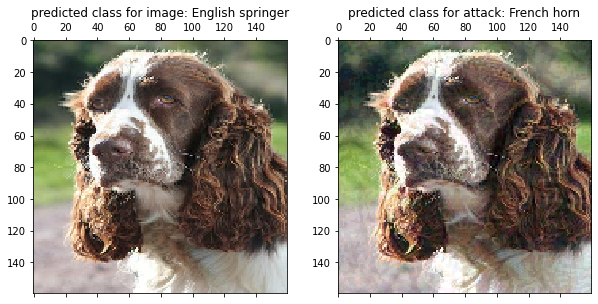

In [71]:
# heres what the adversarial attack looks like in general, these are fish images 
random_idx = random.randint(0, concepts.shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))


ax1.matshow(concepts[random_idx])
ax2.matshow(concepts_attack[random_idx])

ax1.set_title(f"predicted class for image: {label_array[pred_concepts[random_idx].argmax()]}")
ax2.set_title(f"predicted class for attack: {label_array[pred_concepts_attack[random_idx].argmax()]}")

# TCAV stuff

In [6]:
import tcav

In [67]:
counterconcepts_labels = concept_labels
layer_n = 2

use_n = 50
tcav = tcav.TCAV(model)
tcav.use_bottleneck(layer_n)

# calculate sensitivity score relative to adversarial examples
tcav.train_cav(concepts[:use_n], concepts_attack[:use_n])
tcav.calculate_sensitivty(concepts[:use_n], concept_labels[:use_n], concepts_attack[:use_n], concept_labels[:use_n])
scores = tcav.sensitivity_score()

/home/graham/.local/share/virtualenvs/tcav_experiments-udElAgsv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2371: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [68]:
scores

{0: 0.87,
 1: None,
 2: None,
 3: None,
 4: None,
 5: None,
 6: None,
 7: None,
 8: None,
 9: None}

In [63]:

# for layer_n in range(1, len(model.layers)-1):
#     tcav.use_bottleneck(layer_n)
    
#     # calculate sensitivity score relative to adversarial examples
#     tcav.train_cav(concepts, counterconcepts_adversarial)
#     tcav.calculate_sensitivty(concepts, counterconcepts_adversarial)
#     sensitivity_score_adversarial = tcav.sensitivity_score()
    
    
#     # calculate sensitivity score relative to adversarial examples
#     tcav.train_cav(concepts, counterconcepts_noise)
#     tcav.calculate_sensitivty(concepts, counterconcepts_noise)
#     sensitivity_score_noise = tcav.sensitivity_score()
    
#     print(f"===\nlayer n: {layer_n} of layer type: {model.layers[layer_n].name} \nADVERSARIAL: sensitivity_score of {sensitivity_score_adversarial}, NOISE: sensitivity_score: {sensitivity_score_noise}" )

In [64]:
# layer_n = 3
# tcav.use_bottleneck(layer_n)

# # calculate sensitivity score relative to adversarial examples
# tcav.train_cav(concepts, counterconcepts_adversarial)
# tcav.calculate_sensitivty(concepts, counterconcepts_adversarial)
# sensitivity_score_adversarial = tcav.sensitivity_score()


# # calculate sensitivity score relative to adversarial examples
# tcav.train_cav(concepts, counterconcepts_noise)
# tcav.calculate_sensitivty(concepts, counterconcepts_noise)
# sensitivity_score_noise = tcav.sensitivity_score()

# print(f"===\nlayer n: {layer_n} of layer type: {model.layers[layer_n].name} \nADVERSARIAL: sensitivity_score of {sensitivity_score_adversarial}, NOISE: sensitivity_score: {sensitivity_score_noise}" )

# Prelimary take away 

- Im not sure what the above really shows or if it is of any insight into "understanding" the model and how the TCAV scores can be used.  I guess it shows that maybe adversarial attacks can be "snuck through" on layers potentially (where the sensitivity is quite similar between the two, i.e. `block2_pool`)?

- Im a bit confused about if its possible to compare sensitivity scores or if there is perhaps a better way to use the sensitivity scores.  
 
- Also confused about what the "concept" would entail in these.  Does it matter if I have the "concept" as the original image and the counter concept as the attack/noise?

- If you want to understand what a NN is doing, detecting "high level" concepts from activations seems like a very straight forward way but wouldnt be useful for runtime analysis as you need the gradients wrt the labels
    - is there a method that just looks at the linear classifier trained on a layer without respect to the gradients?  what would that show in comparison to this?